## Brighton's Midfield Touchmap

### Imports

In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib import cm
import matplotlib.gridspec as gridspec

# We'll only use a vertical pitch for this tutorial
from mplsoccer import VerticalPitch

from PIL import Image
import urllib
import json
import os

In [237]:
font_path = "../assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("../assets/stylesheets/soc_base.mplstyle")

### Read and clean the data

In [238]:
f = open('data/brighton_leicester_09052022.json', encoding='utf-8')
data = json.load(f)

In [285]:
# Get the touches for the players that we want
players = [
    {
        'name':'Solly March',
        'whoscored_id':'122926',
        'country_id':'eng'
    },
    {
        'name':'Pascal Groß',
        'whoscored_id':'71824',
        'country_id':'ger'
    },
    {
        'name':'Alexis Mac Allister',
        'whoscored_id':'345319',
        'country_id':'arg'
    },
    {
        'name':'Moisés Caicedo',
        'whoscored_id':'410175',
        'country_id':'ecu'
    },
    {
        'name':'Leandro Trossard',
        'whoscored_id':'113994',
        'country_id':'bel'
    },
    {
        'name':'Enock Mwepu',
        'whoscored_id':'353191',
        'country_id':'zam'
    },
]


In [240]:
data_list = []
for player in players:
    for d in data['events']:
        try:
            if (d['playerId'] == int(player['whoscored_id'])) & (d['isTouch']):
                data_list.append(d)
        except:
            continue

In [241]:
x_ = [x['x'] for x in data_list]
y_ = [y['y'] for y in data_list]
playerId = [p['playerId'] for p in data_list]

# Inverted because we are using a vertical pitch
data = pd.DataFrame({'y':x_,'x':y_,'playerId':playerId})

## Example for one player

In [247]:
data_test = data[data['playerId'] == 122926].reset_index(drop=True)

In [248]:
colors = [
    '#efe9e6',
    '#e9e1dd',
    '#e3dad3',
    '#dcd3c9',
    '#d4ccc0',
    '#ccc6b7',
    '#c3bfae',
    '#bab9a6',
    '#b0b39e',
    '#a6ad96',
    '#9ba790',
    '#90a18a',
    '#849b84',
    '#789680',
    '#6c907c',
    '#608a79',
    '#538476',
    '#467e74',
    '#387872',
    '#287271',
]
soc_cm = LinearSegmentedColormap.from_list('SOC', colors, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)

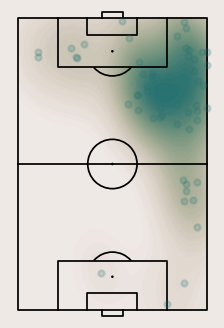

In [250]:
fig = plt.figure(figsize = (4,4), dpi = 100)
ax = plt.subplot(111)
pitch = VerticalPitch(
    pitch_type='opta',
    goal_type='box',
    linewidth=1.25,
    line_color='black',
)
pitch.draw(ax = ax)

pitch.kdeplot(
    data_test.y, data_test.x, 
    ax=ax, shade=True, 
    levels=100, shade_lowest=True,
    cut=4, zorder=-1, cmap='SOC')

ax.scatter(data_test.x, data_test.y, s=20, alpha=0.2, lw=1.5, color='#287271')

Make it into a function

In [310]:
def plot_kdetouches(ax, fig, playerId, countryId, playerName, df=data):
    '''
    Plot kde touches for a specific player.
    '''
    data = df.copy()
    data_player = data[data['playerId'] == int(playerId)].reset_index(drop=True)
    total_touches = data_player.shape[0]
    touches_third = data_player[data_player['y'] >= (100*2)/3].shape[0]/total_touches
    pitch = VerticalPitch(
        pitch_type='opta',
        goal_type='box',
        linewidth=1.25,
        line_color='black',
    )
    pitch.draw(ax=ax)

    pitch.kdeplot(
        data_player.y, data_player.x, 
        ax=ax, shade=True, 
        levels=100, shade_lowest=True,
        cut=4, zorder=-1, cmap='SOC')

    ax.scatter(data_player.x, data_player.y, s=10, alpha=0.2, lw=1.5, color='#287271')
    # -- Transformation functions
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
    ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    # -- Take data coordinates and transform them to normalized figure coordinates
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
    ax_coords = DC_to_NFC((15,109))
    ax_size = 0.018
    image_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_size, ax_size],
        fc='None', anchor='C'
    )
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    player_face = Image.open(urllib.request.urlopen(f"{fotmob_url}{countryId}.png"))
    image_ax.imshow(player_face)
    image_ax.axis("off")
    ax_text(
        x=95, y=115,
        s=f'{playerName}\n<touches {total_touches:.0f} | final third: {touches_third:.0%}>',
        highlight_textprops=[{'size':7, 'weight':'normal'}],
        ax=ax,
        weight='bold',
        size=10,
        font='DM Sans',
        ha='left'
    )
    return ax

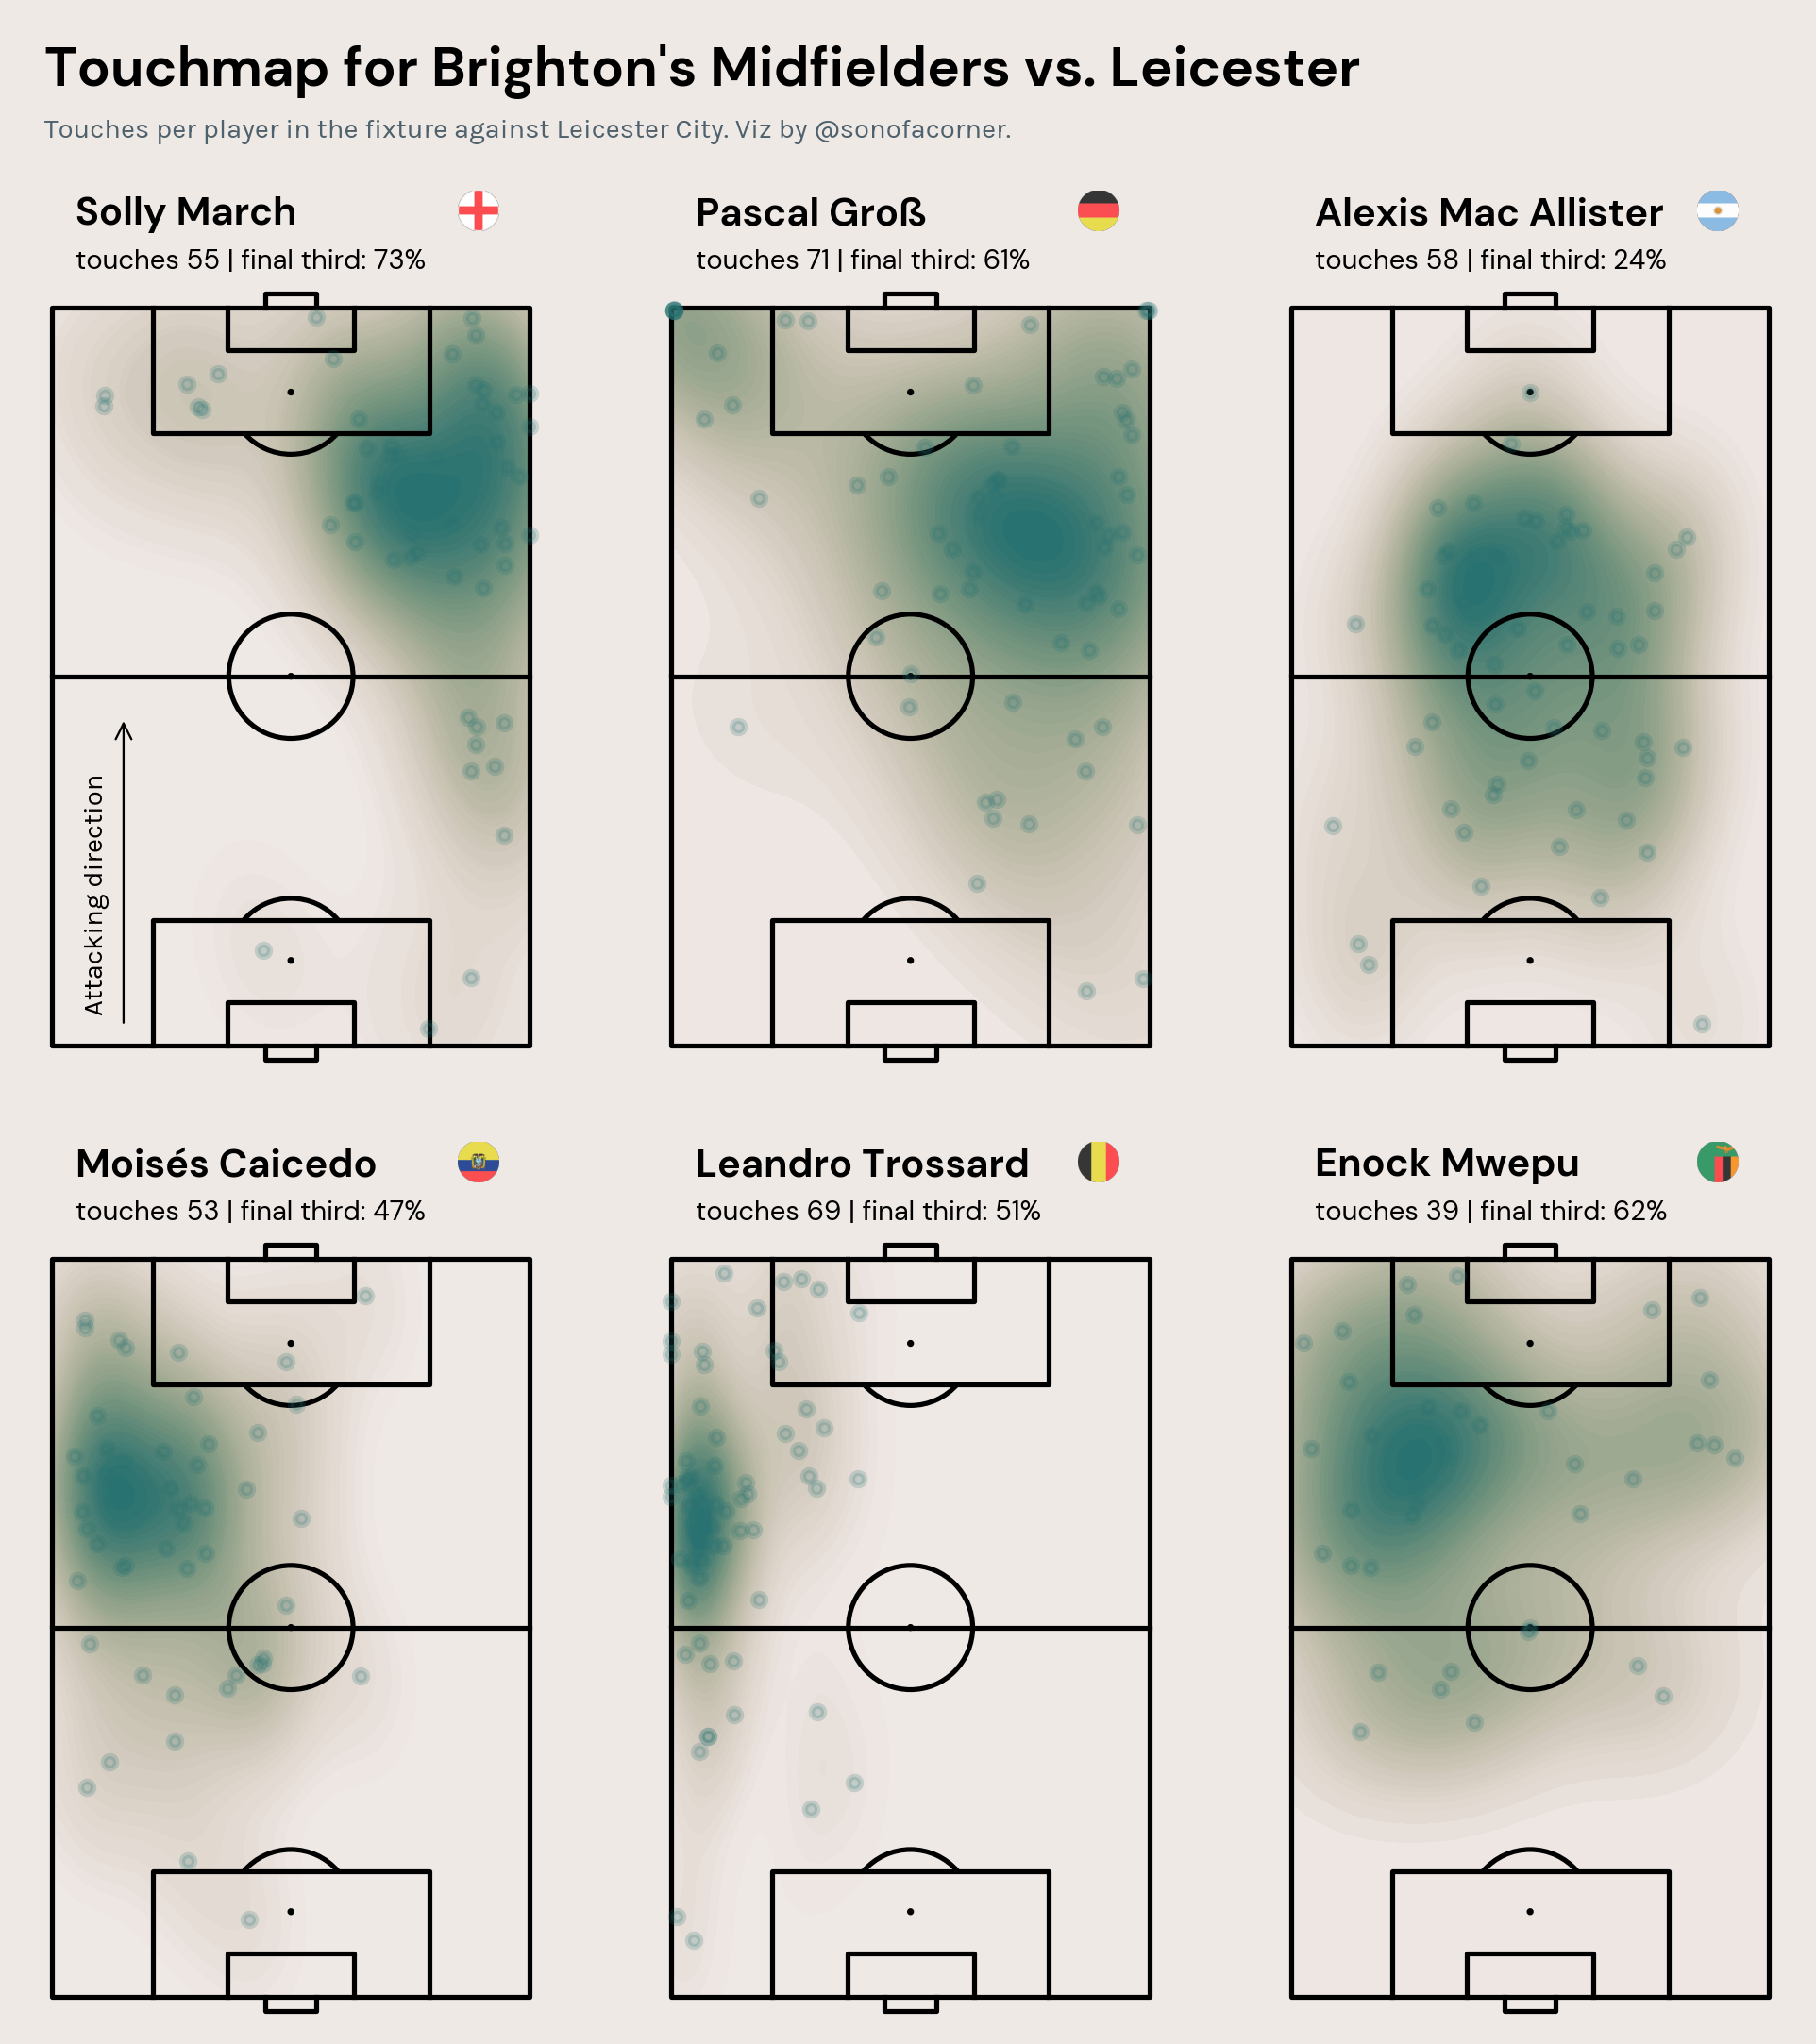

In [318]:
layout_ = '''
    ABC
    DEF
'''

fig = plt.figure(figsize=(8,8), dpi=300)
axs = fig.subplot_mosaic(
    layout_
)

counter = 0
for k, ax in axs.items():
    playerId = players[counter]['whoscored_id']
    countryId = players[counter]['country_id']
    playerName = players[counter]['name']
    plot_kdetouches(ax, fig, playerId, countryId, playerName)
    counter += 1

axs['A'].annotate(
    xy=(93, 5),
    text='Attacking direction',
    rotation=90,
    size=7
)

axs['A'].annotate(
    xy=(85,2),
    xytext=(85,45),
    text='',
    arrowprops=dict(arrowstyle='<-',linewidth=0.55)
)

fig_text(
    x = 0.13, y = .96, 
    s = "Touchmap for Brighton's Midfielders vs. Leicester",
    va = "bottom", ha = "left",
    fontsize = 14, color = "black", font = "DM Sans", weight = "bold"
)
fig_text(
	x = 0.13, y = .94, 
    s = "Touches per player in the fixture against Leicester City. Viz by @sonofacorner.",
	va = "bottom", ha = "left",
	fontsize = 7, color = "#4E616C", font = "Karla"
)

plt.savefig(
	"figures/09052022_brighton_touches.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.savefig(
	"figures/09052022_brighton_touches_tr.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)